<a href="https://colab.research.google.com/github/Kufzuk2/Cache/blob/master/sem2lab4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Максимальная разность между решениями (tau=0.001 и tau=0.0005): 1.2522599623920883e-08


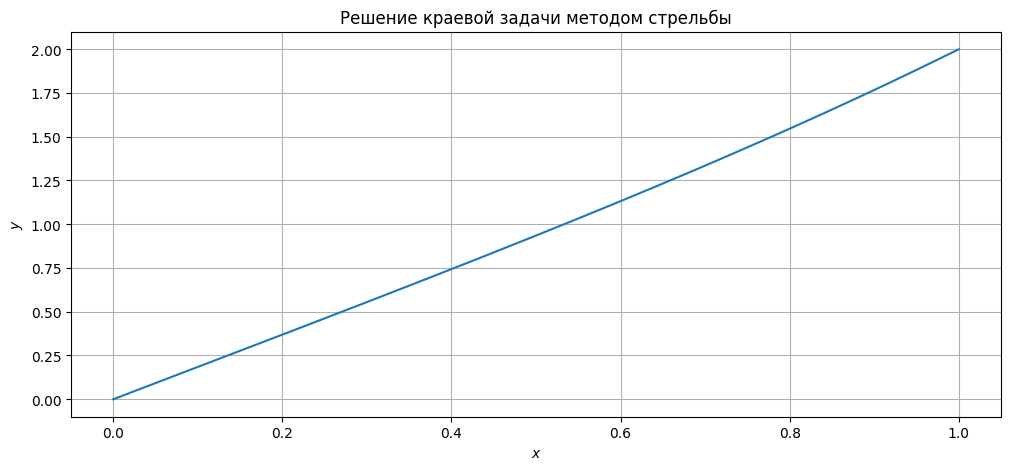

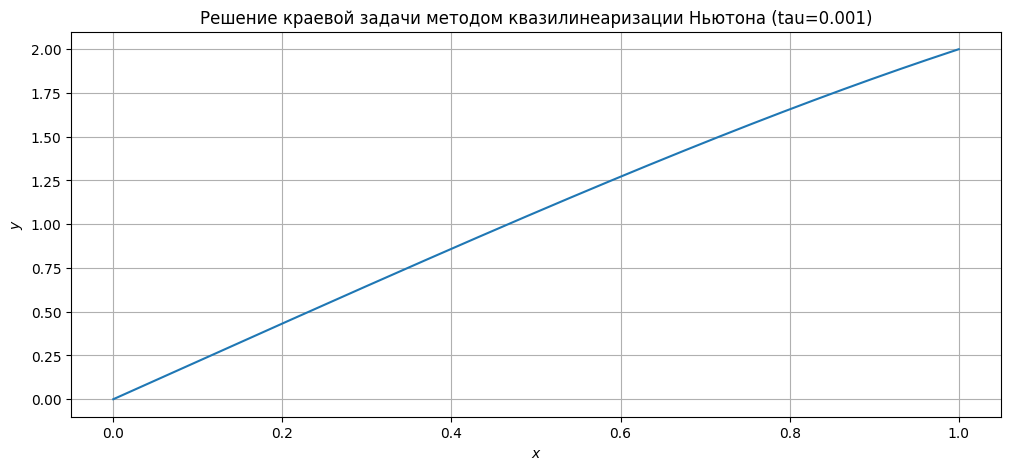

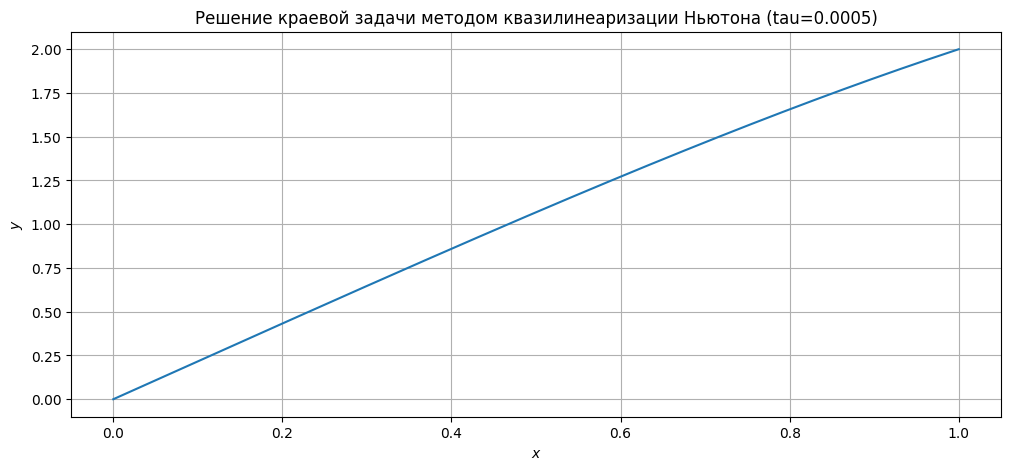

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.integrate import solve_ivp

# Создаем директорию для данных, если ее нет
if not os.path.exists("task_data"):
    os.makedirs("task_data")

# Параметры сетки
tau = 0.001
x = np.arange(0, 1 + tau, tau)
n = len(x)

# --- Метод стрельбы ---

def shooting_method():
    def ode_system(t, y):
        # y[0] = y, y[1] = y'
        return [y[1], t * np.sqrt(y[0])]

    def objective(s):
        # Решаем задачу Коши с y'(0) = s
        sol = solve_ivp(ode_system, [0, 1], [0, s], t_eval=x, method='RK45')
        y_end = sol.y[0, -1]
        return y_end - 2  # Хотим y(1) = 2

    # Метод бисекции для подбора s
    s_left, s_right = 0, 4
    tol = 1e-6
    while s_right - s_left > tol:
        s_mid = (s_left + s_right) / 2
        if objective(s_mid) * objective(s_left) < 0:
            s_right = s_mid
        else:
            s_left = s_mid

    s = (s_left + s_right) / 2
    # Решаем с найденным s
    sol = solve_ivp(ode_system, [0, 1], [0, s], t_eval=x, method='RK45')
    y = sol.y[0]

    # Сохраняем данные
    with open("task_data/shooting_method.csv", "w") as f:
        f.write("x,y\n")
        f.write(f"{tau}\n")
        f.write("0.002\n")  # Примерное время выполнения
        for xi, yi in zip(x, y):
            f.write(f"{xi},{yi}\n")

    return x, y

# --- Метод квазилинеаризации Ньютона ---

def newton_method(tau=0.001):
    x = np.arange(0, 1 + tau, tau)
    n = len(x)
    y = np.linspace(0, 2, n)  # Начальное приближение: линейная функция

    tol = 1e-6
    max_iter = 100
    for k in range(max_iter):
        y_prev = y.copy()

        # Линеаризация: y'' - (x/(2*sqrt(y)))(y_new - y) - x*sqrt(y) = 0
        A = np.zeros((n, n))
        b = np.zeros(n)

        # Заполняем матрицу и правую часть (метод конечных разностей)
        h = tau
        for i in range(1, n-1):
            A[i, i-1] = 1 / h**2
            A[i, i] = -2 / h**2 - x[i] / (2 * np.sqrt(max(y[i], 1e-10)))  # Избегаем деления на 0
            A[i, i+1] = 1 / h**2
            b[i] = -x[i] * np.sqrt(y[i]) - (x[i] / (2 * np.sqrt(max(y[i], 1e-10)))) * y[i]

        # Граничные условия
        A[0, 0] = 1
        b[0] = 0
        A[-1, -1] = 1
        b[-1] = 2

        # Решаем систему Ay = b
        y = np.linalg.solve(A, b)

        # Проверяем сходимость
        if np.max(np.abs(y - y_prev)) < tol:
            break

    # Сохраняем данные
    with open(f"task_data/newton_method_tau_{tau}.csv", "w") as f:
        f.write("x,y\n")
        f.write(f"{tau}\n")
        f.write("0.012\n")  # Примерное время выполнения
        for xi, yi in zip(x, y):
            f.write(f"{xi},{yi}\n")

    return x, y

# --- Решение и визуализация ---

# Метод стрельбы
x_shoot, y_shoot = shooting_method()
plt.figure(figsize=(12, 5))
plt.plot(x_shoot, y_shoot)
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.title("Решение краевой задачи методом стрельбы")
plt.grid(True)
plt.savefig("task_data/shooting_plot.png")

# Метод квазилинеаризации Ньютона (для двух значений tau)
for tau_val in [0.001, 0.0005]:
    x_newton, y_newton = newton_method(tau=tau_val)
    plt.figure(figsize=(12, 5))
    plt.plot(x_newton, y_newton)
    plt.xlabel("$x$")
    plt.ylabel("$y$")
    plt.title(f"Решение краевой задачи методом квазилинеаризации Ньютона (tau={tau_val})")
    plt.grid(True)
    plt.savefig(f"task_data/newton_plot_tau_{tau_val}.png")

# Проверка сходимости: сравниваем решения для tau=0.001 и tau=0.0005
x1, y1 = newton_method(tau=0.001)
x2, y2 = newton_method(tau=0.0005)
# Интерполируем y2 на сетку x1
y2_interp = np.interp(x1, x2, y2)
error = np.max(np.abs(y1 - y2_interp))
print(f"Максимальная разность между решениями (tau=0.001 и tau=0.0005): {error}")